# Deep Learning for the Physical Layer - Encoders

The goal of this notebook is to implement the autoencoder presented by [O'Shea and Hoydis, 2017](https://arxiv.org/pdf/1702.00832.pdf).

We use pytorch to implement the autoencoder presented in the paper

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math
# To make the plots
import matplotlib.pyplot as plt
%matplotlib inline
# To do block encoding (Hamming)
import sk_dsp_comm.fec_block as block
# To supress some strange output at runtime
from IPython.utils import io

If possible we are going to use GPU to train faster

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Pytorch device: %s' % (device))

Pytorch device: cuda:0


Implementing the encoder with pytorch

In [3]:
class Encoder(nn.Module):
    """
    This is going to be the definition of the encoder.
    The encoder in the paper is implemented with Tensorflow
    Layers in Tensorflow:
      - Dense + ReLU. Out M
      - Dense + linear. Out n
      - Normalization (some normalization defined by the paper) Out n
    Layers equivalent in Pytorch:
      - Linear + ReLU. Out M
      - Linear + (nothing). Out n
      - Normalization (some normalization defined by the paper). Is gonna be done in forward function. Out n
    """
    def __init__(self, m, n):
        """
        Initialization of the encoder
        
        Args:
          m (int): Transmitter can have up to M different messages. Each of this messages gets encoded
          n (int): Length of the encoding
        """
        super(Encoder, self).__init__()
        
        self.linear_M = nn.Sequential(
            nn.Linear(in_channels=m, out_channels=m),
            nn.ReLU(),
        )
        
        self.linear_N = nn.Sequential(
            nn.Linear(in_channels=m, out_channels=n),
        )
        
        self.n = n
        
    def forward(self, x):
        """
        Forward pass over x
        
        Args:
          x of shape (batch_size, M): Messages that are going to be encoded
        
        Returns:
          y of shape (batch_size, n): Encoded messages
        """
        x = self.linear_M(x)
        x = self.linear_N(x)
        
        # Doing the normalization to get the final result
        normalization_term = torch.sqrt(n)/torch.sum(torch.sqrt(x**2), dim=1)
        y = x*normalization_term
        
        return y

Implementing the decoder with pytorch

In [4]:
class Decoder(nn.Module):
    """
    This is going to be the definition of the decoder.
    The decoder in the paper is implemented with Tensorflow
    Layers in Tensorflow:
      - Dense + ReLU. Out M
      - Dense + Softmax. Out M
    Layers equivalent in Pytorch:
      - Linear + ReLU. Out M
      - Linear + (ommited). Out M
      Softmax is going to be ommited to use pytorch loss function CrossEntropyLoss
      CrossEntropyLoss combines LogSoftmax and NLLLoss (Negative Log Likelihood) in one single class.
    """
    def __init__(self, m, n):
        """
        Initialization of the decoder
        
        Args:
          m (int): Transmitter can have up to M different messages. Need to decide between this many messages
          n (int): Length of the encoding
        """
        super(Decoder, self).__init__()
        
        self.linear_relu = nn.Sequential(
            nn.Linear(in_channels=n, out_channels=m),
            nn.ReLU(),
        )
        
        self.linear_out = nn.Sequential(
            nn.Linear(in_channels=m, out_channels=m),
        )
        
    def forward(self, x):
        """
        Forward pass over x
        
        Args:
          x of shape (batch_size, n): Encoded messages
        
        Returns:
          y of shape (batch_size, M): Decoded messages
        """
        x = self.linear_relu(x)
        x = self.linear_out(x)
        
        return y

In [5]:
def block_encoder(x, n, k):
    """
    This is going to be the definition of encoding using Hamming
    Args:
        x of shape (batch_size, k): Messages without encoding
        n (int): Length of the encoded messages
        k (int): Length of the actual messages
        
    Returns:
        y of shape (batch_size, n): Encoded messages with Hamming
    """
    # There is no need for encoding
    if n == k:
        # Return as float because that the way encoder.hamm_encoder returns it
        return x
    
    # We initialize the encoder with the number of parity bits that we need
    # According to doc from block.fec_hamming
    # Initialized with j. Where n = 2^j-1. k = n-j.
    encoder = block.fec_hamming(n-k)
    
    # Get the batch size and pre-allocate adequate space for it
    batch_size, _ = x.shape
    encoding_results = np.zeros((batch_size, n), dtype=int)
    
    # Iterate over the batches and get the encoding for all of them
    for i, x_vec in enumerate(x):
        encoding_results[i, :] = encoder.hamm_encoder(x_vec)
    
    return encoding_results

In [6]:
def block_decoder(y, n, k):
    """
    This is going to be the definition of decoding using Hamming
    Args:
        x of shape (batch_size, n): Encoded messages
        n (int): Length of the encoded messages
        k (int): Length of the actual messages
        
    Returns:
        y of shape (batch_size, k): Decoded messages with Hamming
    """
    # There is no need for decoding
    if n == k:
        # Return as float because that the way encoder.hamm_decoder returns it
        return y
    
    # We initialize the decoder with the number of parity bits that we need
    # According to doc from block.fec_hamming
    # Initialized with j. Where n = 2^j-1. k = n-j.
    decoder = block.fec_hamming(n-k)
    
    # Get the batch size and pre-allocate adequate space for it
    batch_size, _ = y.shape
    decoding_results = np.zeros((batch_size, k), dtype=int)
    
    # Iterate over the batches and get the encoding for all of them
    for i, y_vec in enumerate(y):
        decoding_results[i, :] = decoder.hamm_decoder(y_vec)
    
    return decoding_results

Test visually our encoder and decoder

In [7]:
x = np.array([[1, 0, 0, 1], [0, 0, 0, 1]])
print("Sample x")
print(x)
y1 = block_encoder(x, 7, 4)
print("y1. Encoded x with Hamming(7,4)")
print(y1)
z1 = block_decoder(y1, 7, 4)
print("z1. Decoded y1")
print(z1)

print("y2. Not encoded x")
y2 = block_encoder(x, 4, 4)
print(y2)
z2 = block_decoder(y2, 4, 4)
print("z2. Decoded y2")
print(z2)

Sample x
[[1 0 0 1]
 [0 0 0 1]]
(7,4) hamming code object
y1. Encoded x with Hamming(7,4)
[[1 0 0 1 0 1 0]
 [0 0 0 1 1 0 1]]
(7,4) hamming code object
z1. Decoded y1
[[1 0 0 1]
 [0 0 0 1]]
y2. Not encoded x
[[1 0 0 1]
 [0 0 0 1]]
z2. Decoded y2
[[1 0 0 1]
 [0 0 0 1]]


In [8]:
def channel(x, n, k, snr_db):
    """
    Definition of the channel. e.g. Add AWGN to the samples
    Args:
        x of shape (batch_size, k): Encoded messages
        n (int): Length of the encoded messages
        k (int): Length of the actual messages
        snr_db (float): SNR to add noise
        
    Returns:
        x_channel of shape (batch_size, k): x with npose
    """
    snr_lin = 10**(snr_db/10)
    rate = k/n
    n0 = 1/(snr_lin*rate)
    var_channel = math.sqrt(n0/2)
    
    if torch.is_tensor(x):
        x_channel = x + var_channel*torch.randn_like(x)
    else:
        x_channel = x + var_channel*np.random.randn(*x.shape)
    
    return x_channel

In [9]:
print("Sample x")
print(x)
x_channel = channel(x, 7, 4, 8)
print("Noisy x")
print(x_channel)

Sample x
[[1 0 0 1]
 [0 0 0 1]]
Noisy x
[[ 0.91123754  0.70689264  0.08974296  1.01295353]
 [ 0.1588484  -0.39886295  0.13586253  1.29136234]]


In [10]:
def bpsk_communication(x, n, k, snr_db):
    # Encode the messages using Hamming
    x_encoded = block_encoder(x, n, k)
    
    # Signal vector to transmit (modulation)
    s_transmit = 2*x_encoded - 1
    
    # Add the noise
    s_noise = channel(s_transmit, n, k, snr_db)
    
    # Demoludation of the signal
    y = np.sign(s_noise)
    y_enc = (y + 1)/2

    # Decode them using Hamming
    y_decoded = block_decoder(y_enc.astype(int), n, k)
    
    return y_decoded

In [11]:
def bler(x, y):
    # Get the total number of messages
    batch_size, _ = x.shape
    
    # Check where are the errors between received and transmitted
    errors = (x != y)
    # How many errors per block
    errors_block = errors.sum(axis=1)
    # If there was an error in the block count it as bad block
    total_errors = (errors_block > 0).sum()

    return total_errors/batch_size

Small test for BPSK communication and BLER

In [12]:
print("Transmitted x")
print(x)
x_rx = bpsk_communication(x, 7, 4, 8)
print("Received x")
print(x_rx)
print("BLER")
print(bler(x, x_rx))

Transmitted x
[[1 0 0 1]
 [0 0 0 1]]
(7,4) hamming code object
(7,4) hamming code object
Received x
[[1 0 0 1]
 [0 0 0 1]]
BLER
0.0


In [13]:
# Defining the hamming encoding sizes (n, k)
hamming_sizes = [(4, 4), (7, 4), (8, 8), (2, 2)]
snrs_db = np.arange(-4, 10, 1)
n_blocks = 200000

results_y = np.zeros((len(hamming_sizes), len(snrs_db)))

for hamm_n, (n, k) in enumerate(hamming_sizes):
    x = np.random.randint(0, 2, size=(n_blocks, k))
    for snr_n, snr_db in enumerate(snrs_db):
        # Strange output from library sk_dsp_comm.fec_block when doing hamming coding
        # e.g. (7,4) hamming code object
        # Supressing such output with this line
        with io.capture_output() as captured:
            x_rec = bpsk_communication(x, n, k, snr_db)
        block_bler = bler(x, x_rec)
        results_y[hamm_n, snr_n] = block_bler
    print("Finished calculations for BPSK(%d, %d)" % (n, k))

Finished calculations for BPSK(4, 4)
Finished calculations for BPSK(7, 4)
Finished calculations for BPSK(8, 8)
Finished calculations for BPSK(2, 2)


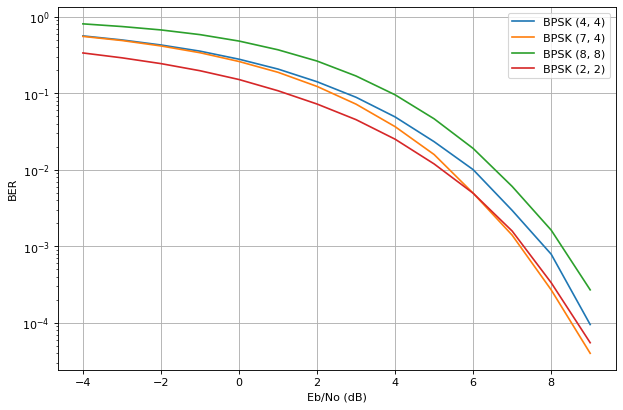

In [14]:
plt.figure(figsize=(9, 6), dpi= 80, facecolor='w')
plt.semilogy(snrs_db, results_y[0,:])
plt.semilogy(snrs_db, results_y[1,:])
plt.semilogy(snrs_db, results_y[2,:])
plt.semilogy(snrs_db, results_y[3,:])
plt.grid(True)
plt.legend(('BPSK (4, 4)','BPSK (7, 4)', 'BPSK (8, 8)', 'BPSK (2, 2)'))
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.show()